In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mlflow

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from tqdm import tqdm
import os

In [2]:
wd = os.getcwd().split("/")
repo_i = wd.index("ml-ops")
repo_path = "/".join(wd[:repo_i+1])
repo_path

'/Users/emmajuansalazar/Documents/spring-mod-2/ml-ops'

# The Data

**Exploring Predictive Health Factors**

[Kaggle Competition](https://www.kaggle.com/competitions/exploring-predictive-health-factors/data?select=train.csv)

Polycystic ovary syndrome (PCOS) is a common endocrine disorder that affects the reproductive health and quality of life of millions of women worldwide. Research has shown that lifestyle choices such as diet, exercise, stress management, etc. have a significant impact on the pathogenesis and symptom relief of PCOS. However, there are still many gaps in research on the relationship between lifestyle and PCOS, especially in terms of individual differences and comprehensive lifestyle interventions.

In order to promote research progress in this field, we are organizing the "Polycystic Ovary Syndrome (PCOS) Lifestyle Impact Research Competition". The aim is to use data-driven methods to deeply analyze the impact of lifestyle choices on PCOS, and provide scientific basis for clinical intervention and health management.

In [3]:
pcos = pd.read_csv(f"{repo_path}/data/pcos/train.csv")

In [4]:
pcos.head()

,ID,Age,Weight_kg,PCOS,Hormonal_Imbalance,Hyperandrogenism,Hirsutism,Conception_Difficulty,Insulin_Resistance,Exercise_Frequency,Exercise_Type,Exercise_Duration,Sleep_Hours,Exercise_Benefit
0,0,20-25,64.0,No,No,No,No,No,No,Rarely,"Cardio (e.g., running, cycling, swimming)",30 minutes,Less than 6 hours,Somewhat
1,1,15-20,55.0,No,No,No,No,No,No,6-8 Times a Week,No Exercise,Less than 30 minutes,6-8 hours,Somewhat
2,2,15-20,91.0,No,No,No,Yes,No,No,Rarely,"Cardio (e.g., running, cycling, swimming)",Less than 30 minutes,6-8 hours,Somewhat
3,3,15-20,56.0,No,No,No,No,No,No,6-8 Times a Week,"Cardio (e.g., running, cycling, swimming)",45 minutes,6-8 hours,Not at All
4,4,15-20,47.0,No,Yes,No,No,No,No,Rarely,No Exercise,Not Applicable,6-8 hours,Not Much


In [5]:
pcos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     210 non-null    int64  
 1   Age                    209 non-null    object 
 2   Weight_kg              208 non-null    float64
 3   PCOS                   210 non-null    object 
 4   Hormonal_Imbalance     208 non-null    object 
 5   Hyperandrogenism       207 non-null    object 
 6   Hirsutism              205 non-null    object 
 7   Conception_Difficulty  209 non-null    object 
 8   Insulin_Resistance     209 non-null    object 
 9   Exercise_Frequency     208 non-null    object 
 10  Exercise_Type          208 non-null    object 
 11  Exercise_Duration      208 non-null    object 
 12  Sleep_Hours            208 non-null    object 
 13  Exercise_Benefit       209 non-null    object 
dtypes: float64(1), int64(1), object(12)
memory usage: 23.1+ KB

In [6]:
pcos = pcos.set_index("ID")
pcos = pcos.iloc[:,[1,0] + list(range(2,13))]

In [7]:
pcos.shape

(210, 13)

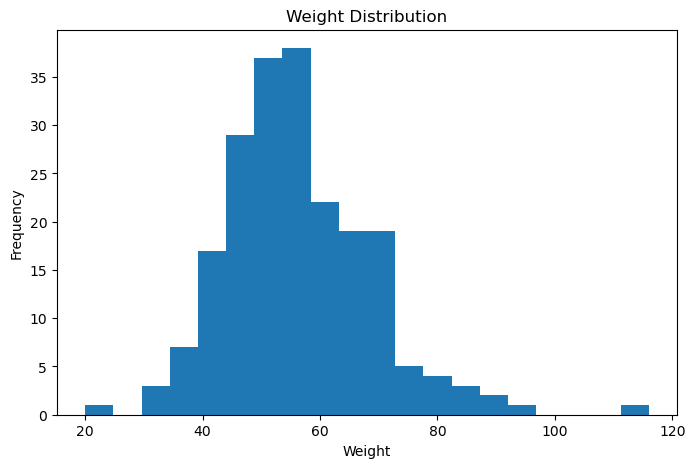

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(pcos['Weight_kg'], bins=20)
plt.title('Weight Distribution')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

In [9]:
for col in pcos.iloc[:, 1:].columns:
    counts = pcos.groupby(col).size().reset_index()
    display(counts)

,Age,0
0,15-20,50
1,20-25,125
2,25-30,4
3,30-25,1
4,30-35,2
5,30-40,1
6,35-44,4
7,45 and above,3
8,Less than 20,18
9,Less than 20-25,1


,PCOS,0
0,No,164
1,Yes,46


,Hormonal_Imbalance,0
0,No,95
1,"No, Yes, not diagnosed by a doctor",1
2,Yes,111
3,Yes Significantly,1


,Hyperandrogenism,0
0,No,175
1,Yes,32


,Hirsutism,0
0,No,148
1,"No, Yes, not diagnosed by a doctor",2
2,Yes,55


,Conception_Difficulty,0
0,No,201
1,"No, Yes, not diagnosed by a doctor",1
2,Yes,1
3,"Yes, diagnosed by a doctor",6


,Insulin_Resistance,0
0,No,185
1,"No, Yes, not diagnosed by a doctor",1
2,Yes,23


,Exercise_Frequency,0
0,1-2 Times a Week,35
1,3-4 Times a Week,23
2,6-8 Times a Week,17
3,6-8 hours,1
4,Less than 6 hours,1
5,Less than usual,1
6,Never,28
7,Rarely,102


,Exercise_Type,0
0,Cardio (e.g.,25
1,"Cardio (e.g., running, cycling, swimming)",51
2,"Cardio (e.g., running, cycling, swimming), Fle...",4
3,"Cardio (e.g., running, cycling, swimming), None",1
4,"Cardio (e.g., running, cycling, swimming), Str...",4
5,"Cardio (e.g., running, cycling, swimming), Str...",2
6,Flexibility and balance (e.g.,1
7,"Flexibility and balance (e.g., yoga, pilates)",16
8,"Flexibility and balance (e.g., yoga, pilates),...",1
9,High-intensity interval training (HIIT),3


,Exercise_Duration,0
0,20 minutes,1
1,30 minutes,33
2,30 minutes to 1 hour,1
3,45 minutes,17
4,Less than 30 minutes,62
5,Less than 6 hours,1
6,More than 30 minutes,7
7,Not Applicable,86


,Sleep_Hours,0
0,3-4 hours,1
1,6-8 hours,135
2,9-12 hours,13
3,Less than 6 hours,58
4,More than 12 hours,1


,Exercise_Benefit,0
0,Not Much,21
1,Not at All,26
2,Somewhat,137
3,Yes Significantly,25


## Fixing category mismatches

In [10]:
# Age
pcos.loc[(pcos["Age"] == "Less than 20") | (pcos["Age"] == "Less than 20-25"), "Age"] = "15-20"

# Hormonal_Imbalance
pcos.loc[pcos["Hormonal_Imbalance"] == "Yes Significantly", "Hormonal_Imbalance"] = "Yes"
pcos.loc[pcos["Hormonal_Imbalance"] == "No, Yes, not diagnosed by a doctor", "Hormonal_Imbalance"] = "Unknown"

# Hirsutism
pcos.loc[pcos["Hirsutism"] == "No, Yes, not diagnosed by a doctor", "Hirsutism"] = "Unknown"

# Conception_Difficulty
pcos.loc[pcos["Conception_Difficulty"] == "Yes, diagnosed by a doctor", "Conception_Difficulty"] = "Yes"
pcos.loc[pcos["Conception_Difficulty"] == "No, Yes, not diagnosed by a doctor", "Conception_Difficulty"] = "Unknown"

# Insulin_Resistance
pcos.loc[pcos["Insulin_Resistance"] == "No, Yes, not diagnosed by a doctor", "Insulin_Resistance"] = "Unknown"

# Exercise_Frequency
pcos.loc[pcos["Exercise_Frequency"].isin(["6-8 hours", "Less than 6 hours", "Less than usual"]), "Exercise_Frequency"] = "1-2 Times a Week"

# Exercise_Type
pcos["Exercise_Type"] = pcos["Exercise_Type"].fillna("Unknown")
pcos.loc[pcos["Exercise_Type"].str.startswith("Cardio"), "Exercise_Type"] = "Cardio"
pcos.loc[pcos["Exercise_Type"].str.startswith("Flexibility"), "Exercise_Type"] = "Flexibility and balance"
pcos.loc[pcos["Exercise_Type"].str.startswith("Strength"), "Exercise_Type"] = "Strength training"
pcos.loc[pcos["Exercise_Type"] == "Somewhat", "Exercise_Type"] = "Unknown"

# Exercise_Duration
pcos.loc[pcos["Exercise_Duration"] == "20 minutes", "Exercise_Duration"] = "Less than 30 minutes"
pcos.loc[pcos["Exercise_Duration"] == "30 minutes to 1 hour", "Exercise_Duration"] = "More than 30 minutes"
pcos.loc[pcos["Exercise_Duration"] == "45 minutes", "Exercise_Duration"] = "More than 30 minutes"
pcos.loc[pcos["Exercise_Duration"] == "Less than 6 hours", "Exercise_Duration"] = "Not Applicable"

# Sleep Hours
pcos.loc[pcos["Sleep_Hours"] == "3-4 hours", "Sleep_Hours"] = "Less than 6 hours"

# Target Variable: PCOS
pcos.loc[pcos["PCOS"] == "Yes", "PCOS"] = 1
pcos.loc[pcos["PCOS"] == "No", "PCOS"] = 0


In [11]:
for col in pcos.iloc[:, 1:].columns:
    counts = pcos.groupby(col).size().reset_index()
    display(counts)

,Age,0
0,15-20,69
1,20-25,125
2,25-30,4
3,30-25,1
4,30-35,2
5,30-40,1
6,35-44,4
7,45 and above,3


,PCOS,0
0,0,164
1,1,46


,Hormonal_Imbalance,0
0,No,95
1,Unknown,1
2,Yes,112


,Hyperandrogenism,0
0,No,175
1,Yes,32


,Hirsutism,0
0,No,148
1,Unknown,2
2,Yes,55


,Conception_Difficulty,0
0,No,201
1,Unknown,1
2,Yes,7


,Insulin_Resistance,0
0,No,185
1,Unknown,1
2,Yes,23


,Exercise_Frequency,0
0,1-2 Times a Week,38
1,3-4 Times a Week,23
2,6-8 Times a Week,17
3,Never,28
4,Rarely,102


,Exercise_Type,0
0,Cardio,87
1,Flexibility and balance,18
2,High-intensity interval training (HIIT),3
3,No Exercise,90
4,Strength training,9
5,Unknown,3


,Exercise_Duration,0
0,30 minutes,33
1,Less than 30 minutes,63
2,More than 30 minutes,25
3,Not Applicable,87


,Sleep_Hours,0
0,6-8 hours,135
1,9-12 hours,13
2,Less than 6 hours,59
3,More than 12 hours,1


,Exercise_Benefit,0
0,Not Much,21
1,Not at All,26
2,Somewhat,137
3,Yes Significantly,25


## Missing value inputation

Since we have at most 5 missing values in any which column, let's inpute the missing values with the mode/mean.

In [12]:
pcos.isnull().sum()

Weight_kg                2
Age                      1
PCOS                     0
Hormonal_Imbalance       2
Hyperandrogenism         3
Hirsutism                5
Conception_Difficulty    1
Insulin_Resistance       1
Exercise_Frequency       2
Exercise_Type            0
Exercise_Duration        2
Sleep_Hours              2
Exercise_Benefit         1
dtype: int64

In [13]:
float(pcos["Weight_kg"].mean())

56.159615384615385

In [14]:
# Mean for the Weight Column
mean_weight = float(pcos["Weight_kg"].mean())
pcos["Weight_kg"] = pcos["Weight_kg"].fillna(mean_weight)

for col in pcos.iloc[:, 1:].columns:
    mode_value = pcos[col].mode()[0]
    pcos[col] = pcos[col].fillna(mode_value)

/var/folders/bn/8l9zg4092yg1r262fl2zn9nw0000gn/T/ipykernel_44243/3599572613.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pcos[col] = pcos[col].fillna(mode_value)


In [15]:
pcos.isnull().sum()

Weight_kg                0
Age                      0
PCOS                     0
Hormonal_Imbalance       0
Hyperandrogenism         0
Hirsutism                0
Conception_Difficulty    0
Insulin_Resistance       0
Exercise_Frequency       0
Exercise_Type            0
Exercise_Duration        0
Sleep_Hours              0
Exercise_Benefit         0
dtype: int64

In [16]:
pcos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 0 to 209
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Weight_kg              210 non-null    float64
 1   Age                    210 non-null    object 
 2   PCOS                   210 non-null    int64  
 3   Hormonal_Imbalance     210 non-null    object 
 4   Hyperandrogenism       210 non-null    object 
 5   Hirsutism              210 non-null    object 
 6   Conception_Difficulty  210 non-null    object 
 7   Insulin_Resistance     210 non-null    object 
 8   Exercise_Frequency     210 non-null    object 
 9   Exercise_Type          210 non-null    object 
 10  Exercise_Duration      210 non-null    object 
 11  Sleep_Hours            210 non-null    object 
 12  Exercise_Benefit       210 non-null    object 
dtypes: float64(1), int64(1), object(11)
memory usage: 23.0+ KB


In [17]:
pcos = pcos.iloc[:, [0, 1] + list(range(3,13)) + [2]]

In [18]:
for col in pcos.iloc[:, 1:12].columns:
    pcos[col] = pcos[col].astype('category')

In [19]:
pcos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 0 to 209
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Weight_kg              210 non-null    float64 
 1   Age                    210 non-null    category
 2   Hormonal_Imbalance     210 non-null    category
 3   Hyperandrogenism       210 non-null    category
 4   Hirsutism              210 non-null    category
 5   Conception_Difficulty  210 non-null    category
 6   Insulin_Resistance     210 non-null    category
 7   Exercise_Frequency     210 non-null    category
 8   Exercise_Type          210 non-null    category
 9   Exercise_Duration      210 non-null    category
 10  Sleep_Hours            210 non-null    category
 11  Exercise_Benefit       210 non-null    category
 12  PCOS                   210 non-null    int64   
dtypes: category(11), float64(1), int64(1)
memory usage: 9.2 KB


# Dataset split

In [20]:
X = pcos.drop(columns="PCOS")
y = pcos["PCOS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Modeling

We'll use three strategies:

- Linear Regression
- Decision Tree Classifier
- Random Forest Classifier

In [21]:
mlflow.set_tracking_uri('https://mlops-25-634030133521.us-west2.run.app')
mlflow.set_experiment('pcos-experiments')

2025/04/17 14:29:22 INFO mlflow.tracking.fluent: Experiment with name 'pcos-experiments' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1744925362472, experiment_id='1', last_update_time=1744925362472, lifecycle_stage='active', name='pcos-experiments', tags={}>

Run

`mlflow ui --backend-store-uri sqlite:///mlflow.db`

to open the mlflow UI.

In [22]:
# Feature groups
numerical_features = ["Weight_kg"]
categorical_features = [col for col in X.columns if col != "Weight_kg"]

# Preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [23]:
def run_experiments(pipeline, grid, title):
    for i, params in tqdm(enumerate(grid)):
        with mlflow.start_run(run_name=f"{title} - Combo {i}"):
            try:
                # Fit the model
                pipeline.set_params(**params)
                pipeline.fit(X_train, y_train)

                # Evaluate on test set
                y_pred = pipeline.predict(X_test)
                test_accuracy = accuracy_score(y_test, y_pred)

                # Log parameters and metrics
                mlflow.log_params(params)
                mlflow.log_metric("test_accuracy", test_accuracy)

                # Log model
                # Create a single-row input example (after preprocessing)
                sample_input = X_test.iloc[[0]]  # wrap in double brackets to keep as DataFrame
                # Log the model with example and signature auto-inferred
                mlflow.sklearn.log_model(
                    sk_model=pipeline,
                    artifact_path="model",
                    input_example=sample_input,
                    signature=mlflow.models.infer_signature(sample_input, pipeline.predict(sample_input))
                )
            except Exception as e:
                mlflow.set_tag("run_status", "failed")
                mlflow.log_params(params)
                mlflow.set_tag("error_message", str(e))

In [24]:
def run_experiments_w_feature_selection(pipeline, grid, title):
    for i, params in tqdm(enumerate(grid)):
        with mlflow.start_run(run_name=f"{title} - Combo {i}"):
            try:
                # Fit the model
                pipeline.set_params(**params)
                pipeline.fit(X_train, y_train)

                # Evaluate on test set
                y_pred = pipeline.predict(X_test)
                test_accuracy = accuracy_score(y_test, y_pred)

                # Log parameters and metrics
                mlflow.log_params(params)
                mlflow.log_metric("test_accuracy", test_accuracy)

                # Log model
                # Create a single-row input example (after preprocessing)
                sample_input = X_test.iloc[[0]]  # wrap in double brackets to keep as DataFrame
                # Log the model with example and signature auto-inferred
                mlflow.sklearn.log_model(
                    sk_model=pipeline,
                    artifact_path="model",
                    input_example=sample_input,
                    signature=mlflow.models.infer_signature(sample_input, pipeline.predict(sample_input))
                )
                # Log selected feature names
                preprocessor = pipeline.named_steps["preprocessor"]
                feature_selector = pipeline.named_steps["feature_selection"]

                # Get full feature names
                ohe = preprocessor.named_transformers_["cat"]
                cat_feature_names = ohe.get_feature_names_out(categorical_features)
                all_feature_names = numerical_features + list(cat_feature_names)

                # Mask of selected features
                selected_mask = feature_selector.get_support()
                selected_features = [name for name, selected in zip(all_feature_names, selected_mask) if selected]

                # Log to MLflow
                mlflow.log_text("\n".join(selected_features), artifact_file="selected_features.txt")
        
            except Exception as e:
                
                mlflow.set_tag("run_status", "failed")
                mlflow.log_params(params)
                mlflow.set_tag("error_message", str(e))

## 1. Logistic Regression

In [25]:
# Classifier pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

# Hyperparameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2', None],
    'classifier__solver': ['lbfgs', 'liblinear', 'saga']
}

# Parameter Grid
grid = ParameterGrid(param_grid)

# Running the different experiments
run_experiments(pipeline, grid, "Logistic Regression")

1it [00:00,  1.10it/s]

🏃 View run Logistic Regression - Combo 0 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/b1319f6b0f264462b78ac2f9f93c2bb2
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


2it [00:07,  4.48s/it]

🏃 View run Logistic Regression - Combo 1 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/2c636891323a455493675a41959c490c
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


3it [00:12,  4.34s/it]

🏃 View run Logistic Regression - Combo 2 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/ff697c68ed5042438acb2260aef1361d
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


4it [00:16,  4.27s/it]

🏃 View run Logistic Regression - Combo 3 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/6ec0d8a982334a5fa6e3ee6c0582caa0
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


5it [00:20,  4.41s/it]

🏃 View run Logistic Regression - Combo 4 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/7ea69701ac2b4faba43c34823e5cb876
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1
🏃 View run Logistic Regression - Combo 5 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/fcafe145dd6b4418af78b31e6147ea81
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


7it [00:29,  4.29s/it]

🏃 View run Logistic Regression - Combo 6 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/bf9ea03ade5142b6bb7a5f6cde41ec5e
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


8it [00:29,  3.07s/it]

🏃 View run Logistic Regression - Combo 7 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/59f1efa34cb940e68220add92a756a4d
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


9it [00:34,  3.45s/it]

🏃 View run Logistic Regression - Combo 8 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/b65c9cea41a94e90b442c568f9741acb
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


10it [00:34,  2.55s/it]

🏃 View run Logistic Regression - Combo 9 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/96a53ff7a978481490d2dbb782683a1b
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


11it [00:39,  3.37s/it]

🏃 View run Logistic Regression - Combo 10 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/8b2578f6ccd34339bd1b4033c9e7b3e3
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


12it [00:45,  4.04s/it]

🏃 View run Logistic Regression - Combo 11 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/1824cd3f9c294bd492ea8053a87b3928
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


13it [00:49,  4.01s/it]

🏃 View run Logistic Regression - Combo 12 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/b66fe9d4e0fb4382a3893c6c1ccb838a
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


14it [00:53,  4.01s/it]

🏃 View run Logistic Regression - Combo 13 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/9c8d6ef9eefe4879804300dcad268031
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


15it [00:58,  4.35s/it]

🏃 View run Logistic Regression - Combo 14 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/1dec4c8c8a7044bf8bb1f516ec646385
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


16it [01:02,  4.20s/it]

🏃 View run Logistic Regression - Combo 15 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/9e1fbff577c143038a587959369953d6
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


17it [01:02,  3.09s/it]

🏃 View run Logistic Regression - Combo 16 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/07ba63f15ec9403e8cf5bb8d20ec165b
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


18it [01:07,  3.41s/it]

🏃 View run Logistic Regression - Combo 17 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/f21df53b9f444475970fb3581c7e58aa
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


19it [01:07,  2.55s/it]

🏃 View run Logistic Regression - Combo 18 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/45521394d263428fbb92523e43e84e34
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


20it [01:11,  3.04s/it]

🏃 View run Logistic Regression - Combo 19 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/a4025fb0e1104ddb8fec890c222c69d1
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


21it [01:15,  3.38s/it]

🏃 View run Logistic Regression - Combo 20 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/1518720071ca46329b118fce51e62309
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


22it [01:20,  3.65s/it]

🏃 View run Logistic Regression - Combo 21 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/60eb572851704b2cb7eb6a0099f90400
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


23it [01:25,  4.13s/it]

🏃 View run Logistic Regression - Combo 22 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/3a713f70459849ac93df6d8f4d0ce084
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


24it [01:29,  4.13s/it]

🏃 View run Logistic Regression - Combo 23 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/795af85b599e4cfb990a8812499cb919
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


25it [01:33,  4.14s/it]

🏃 View run Logistic Regression - Combo 24 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/741dbd1994e643acb137b050cd1e51ce
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


26it [01:34,  3.09s/it]

🏃 View run Logistic Regression - Combo 25 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/a63f0acf85c148ce8fb27a31546d54be
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


27it [01:39,  3.54s/it]

🏃 View run Logistic Regression - Combo 26 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/f7ca6bec0f8b4969be375a5c6676e0f4
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


28it [01:39,  2.63s/it]

🏃 View run Logistic Regression - Combo 27 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/288ec1a233d94e8bad5444ed822e36b4
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


29it [01:43,  3.09s/it]

🏃 View run Logistic Regression - Combo 28 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/939cabd7f12c48db8321dccb0e26a667
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


30it [01:47,  3.45s/it]

🏃 View run Logistic Regression - Combo 29 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/eedd3b4d3ba346aa9ffde58939cc21e2
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


31it [01:52,  3.81s/it]

🏃 View run Logistic Regression - Combo 30 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/f71bba75743a4dd8a0081f3eb5a2cbb9
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


32it [01:56,  3.95s/it]

🏃 View run Logistic Regression - Combo 31 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/3de593602213497282d172dfdd257331
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


33it [02:01,  4.01s/it]

🏃 View run Logistic Regression - Combo 32 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/f4e180c385a3411e9bda00c0003faaa4
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


34it [02:05,  4.06s/it]

🏃 View run Logistic Regression - Combo 33 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/4667d7ce1c924c9cbe60bf04ddbd0ddf
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


35it [02:05,  2.98s/it]

🏃 View run Logistic Regression - Combo 34 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/d8c8cdca88cb4d2da31a8640c072eb72
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


36it [02:09,  3.61s/it]

🏃 View run Logistic Regression - Combo 35 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/40b5d4bc473a467bbc36e9d33fbbbed2
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


### With Feature selection

In [26]:
feature_selector = SelectFromModel(LogisticRegression(penalty="l1", solver="liblinear", random_state=42))

# Classifier pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selection", feature_selector),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

# Hyperparameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1'],
    'classifier__solver': ['lbfgs', 'liblinear'],
    "feature_selection__threshold": ["mean", "median", 0.01]
}

# Parameter Grid
grid = ParameterGrid(param_grid)

# Running the different experiments
run_experiments_w_feature_selection(pipeline, grid, "Logistic Regression + Feature Selection")

1it [00:00,  1.92it/s]

🏃 View run Logistic Regression + Feature Selection - Combo 0 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/3376f2b3e57f41a2b1a9c1eae34e8257
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


2it [00:00,  2.26it/s]

🏃 View run Logistic Regression + Feature Selection - Combo 1 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/92bcbd0c8ad446fb850b3d7fd87c69f8
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


3it [00:01,  2.58it/s]

🏃 View run Logistic Regression + Feature Selection - Combo 2 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/c69ae4163a80455ba76201c93457afad
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


4it [00:06,  2.18s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 3 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/431456b1a7ab44ec802d01d7c1c09ee1
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


5it [00:11,  3.30s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 4 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/808259bfc65e47d38d3d2f4bf8dcb89e
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


6it [00:15,  3.66s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 5 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/56b29fa106664e5ab586b02d7354b981
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


7it [00:16,  2.63s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 6 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/567a6c9791844b3eb3478b2a36051cf4
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


8it [00:16,  1.94s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 7 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/55e8e6126d894fe18bfb6784906fcaaa
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


9it [00:17,  1.48s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 8 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/ab8c7229ad5949588b7ddb9d9fda326f
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


10it [00:21,  2.48s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 9 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/ce7bcada32ff4109ba84a2eccea66c15
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


11it [00:26,  3.17s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 10 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/116213099af04b8aa1c6efc217d473e7
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


12it [00:31,  3.61s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 11 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/5c5b30ff0a5d4d94882fa7d25aa5576e
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


13it [00:31,  2.61s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 12 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/c0bec766fdf14d8cb897ffeb31515049
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


14it [00:31,  1.93s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 13 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/595dcf63a49d4facadcfc83b69e80f10
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


15it [00:32,  1.48s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 14 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/53241dc4208e4447802a2d36c24758fa
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


16it [00:36,  2.38s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 15 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/88e94c80843d415da1679e597077e683
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


17it [00:41,  3.16s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 16 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/095da276615e4aaebd77c400222030ed
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


18it [00:47,  3.78s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 17 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/0a91f22132d64aedb29368269cecc197
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


19it [00:47,  2.80s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 18 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/39b2102e05684797abb1b83d0f04c855
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


20it [00:47,  2.05s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 19 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/8e4a5df628ba4dbab8eacbc476682d1f
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


21it [00:48,  1.57s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 20 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/0fae65cd192e4c2d8ab0999303da33b2
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


22it [00:52,  2.48s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 21 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/e4a89a901e684a809d387d43bf29cf5e
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


23it [00:57,  3.13s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 22 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/b1296382b6be4551883660872ad4aa57
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


24it [01:02,  2.59s/it]

🏃 View run Logistic Regression + Feature Selection - Combo 23 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/267eb1cc02284518b278875ecd9846c8
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


## 2. Decision Tree Classifier

In [27]:
# Classifier pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

# Hyperparameter grid
param_grid = {
    "classifier__max_depth": [3, 5, 10, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__criterion": ["gini", "entropy"]
}

# Parameter Grid
grid = ParameterGrid(param_grid)

# Running the different experiments
run_experiments(pipeline, grid, "Decision Tree")

1it [00:03,  3.76s/it]

🏃 View run Decision Tree - Combo 0 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/48814fba18bf43e49278e817e374466a
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


2it [00:07,  3.98s/it]

🏃 View run Decision Tree - Combo 1 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/72591dc437c34e379d23ee8df2792f7d
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


3it [00:12,  4.08s/it]

🏃 View run Decision Tree - Combo 2 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/1f77fd789c844aa08de105dc889c096d
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


4it [00:16,  4.15s/it]

🏃 View run Decision Tree - Combo 3 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/3f0b5989424c4599b7fae48061fff19a
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


5it [00:20,  4.23s/it]

🏃 View run Decision Tree - Combo 4 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/589691784f744e3186c282ecbd5cf70c
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


6it [00:24,  4.16s/it]

🏃 View run Decision Tree - Combo 5 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/8cdb78b020264d009d7db82ee1c38c60
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


7it [00:29,  4.35s/it]

🏃 View run Decision Tree - Combo 6 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/5bb6a6d971594fd38c78bc7d502e6faf
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


8it [00:33,  4.40s/it]

🏃 View run Decision Tree - Combo 7 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/9e852ff48b1b4d2e831fef513f0dc2ca
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


9it [00:37,  4.25s/it]

🏃 View run Decision Tree - Combo 8 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/edba2575923a4372867de75cbce43282
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


10it [00:42,  4.33s/it]

🏃 View run Decision Tree - Combo 9 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/e1b8ff467b5048e394dc150c2d178f7d
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


11it [00:46,  4.32s/it]

🏃 View run Decision Tree - Combo 10 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/bd6eda546dc449299a748b9910d812bf
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


12it [00:50,  4.25s/it]

🏃 View run Decision Tree - Combo 11 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/468506b7ba474bb69562e0b0405fd005
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


13it [00:55,  4.25s/it]

🏃 View run Decision Tree - Combo 12 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/bc563c32eb404e7795db4576fdf2593c
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


14it [00:59,  4.27s/it]

🏃 View run Decision Tree - Combo 13 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/d2833338083d45e5b75dae33c4d21812
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


15it [01:03,  4.15s/it]

🏃 View run Decision Tree - Combo 14 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/07ca0f726033456f8ee0af07285bf53b
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


16it [01:07,  4.24s/it]

🏃 View run Decision Tree - Combo 15 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/0f6e88399e3c4aecaa8e7e98f15fedb9
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


17it [01:11,  4.23s/it]

🏃 View run Decision Tree - Combo 16 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/52054b37386542c3a069ec7d26dbc74d
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


18it [01:16,  4.22s/it]

🏃 View run Decision Tree - Combo 17 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/3c90d54e072340699ae239ee0ec9345b
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


19it [01:20,  4.18s/it]

🏃 View run Decision Tree - Combo 18 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/fdbf9bea63a64825801bd42dc3a22db0
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


20it [01:24,  4.20s/it]

🏃 View run Decision Tree - Combo 19 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/8e6431c99c3448af8d343917d51039ad
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


21it [01:28,  4.13s/it]

🏃 View run Decision Tree - Combo 20 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/05130b7e0c274098ab7b575a385d0890
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


22it [01:32,  4.07s/it]

🏃 View run Decision Tree - Combo 21 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/850edafb975340e08dea09ec206ae2db
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


23it [01:37,  4.27s/it]

🏃 View run Decision Tree - Combo 22 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/6f717d35758845a189c8202e9b56e0d2
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


24it [01:41,  4.22s/it]

🏃 View run Decision Tree - Combo 23 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/cc75699dbb53439d81dafb50e5d5c6ce
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


### With Feature selection

In [28]:
feature_selector = SelectFromModel(DecisionTreeClassifier(random_state=42))

# Classifier pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selection", feature_selector),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

# Hyperparameter grid
param_grid = {
    "feature_selection__threshold": ["mean", "median", 0.01],
    "classifier__max_depth": [None, 5, 10],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__criterion": ["gini", "entropy"]
}

# Parameter Grid
grid = ParameterGrid(param_grid)

# Running the different experiments
run_experiments_w_feature_selection(pipeline, grid, "Decision Tree + Feature Selection")

0it [00:00, ?it/s]

🏃 View run Decision Tree + Feature Selection - Combo 0 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/cff58eaf3bde4d8e9744628c2910fcb9
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


2it [00:09,  4.59s/it]

🏃 View run Decision Tree + Feature Selection - Combo 1 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/221e61b237b74d19a6a56cf61518bba2
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


3it [00:13,  4.62s/it]

🏃 View run Decision Tree + Feature Selection - Combo 2 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/d859777ec2ff47578103d218a23f6d07
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


4it [00:18,  4.52s/it]

🏃 View run Decision Tree + Feature Selection - Combo 3 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/238aeb9f4e73436597f10933291c75e6
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


5it [00:22,  4.51s/it]

🏃 View run Decision Tree + Feature Selection - Combo 4 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/8956d6a2ce7a4bceb69c070b9e075679
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


6it [00:27,  4.52s/it]

🏃 View run Decision Tree + Feature Selection - Combo 5 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/5788a4afd05e4f8b94b600693c4e1460
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


7it [00:32,  4.83s/it]

🏃 View run Decision Tree + Feature Selection - Combo 6 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/9b03424fde214aaea8d8ed89b96fc3e4
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1
🏃 View run Decision Tree + Feature Selection - Combo 7 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/812f1f7ed0334d8e8e31ba4b3846e923
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


9it [00:42,  4.76s/it]

🏃 View run Decision Tree + Feature Selection - Combo 8 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/68a596380ba04567bb5b15eec9d2bd1b
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


10it [00:47,  4.84s/it]

🏃 View run Decision Tree + Feature Selection - Combo 9 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/972c546bad644488943d26f483c96a4e
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


11it [00:52,  4.83s/it]

🏃 View run Decision Tree + Feature Selection - Combo 10 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/13e4aa687f6b4dbd8e2a39dca992fb5f
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


12it [00:56,  4.74s/it]

🏃 View run Decision Tree + Feature Selection - Combo 11 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/7781142233344229af1ef08fdc4ca66f
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


13it [01:01,  4.67s/it]

🏃 View run Decision Tree + Feature Selection - Combo 12 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/173640c7d9f84913ba9c0f75ab0f7e06
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


14it [01:05,  4.64s/it]

🏃 View run Decision Tree + Feature Selection - Combo 13 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/a7c8ee079a5346e18422922386e3de91
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


15it [01:10,  4.61s/it]

🏃 View run Decision Tree + Feature Selection - Combo 14 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/e66903c1dd9e4825943d524377fb6782
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


16it [01:15,  4.78s/it]

🏃 View run Decision Tree + Feature Selection - Combo 15 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/7292213c591945df8c478b640c57902f
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


17it [01:20,  4.86s/it]

🏃 View run Decision Tree + Feature Selection - Combo 16 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/2e9bfc9de5d94eaf8f112cf26aef009b
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


18it [01:25,  4.84s/it]

🏃 View run Decision Tree + Feature Selection - Combo 17 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/c58c114fe93046deba832e1f05d7e1e7
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


19it [01:29,  4.67s/it]

🏃 View run Decision Tree + Feature Selection - Combo 18 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/7a01a2f0df1c4b9a91c4d388aa865616
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


20it [01:34,  4.86s/it]

🏃 View run Decision Tree + Feature Selection - Combo 19 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/c8c2a56106f348ea996895e8d8232ade
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


21it [01:39,  4.68s/it]

🏃 View run Decision Tree + Feature Selection - Combo 20 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/e5d53cdcf09449f680bf12b5f398c039
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


22it [01:44,  4.84s/it]

🏃 View run Decision Tree + Feature Selection - Combo 21 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/9ba318df05a64fda9ba2a46c60d3b081
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


23it [01:48,  4.77s/it]

🏃 View run Decision Tree + Feature Selection - Combo 22 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/4dfd50d23db34457b5d4f1962ac78564
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


24it [01:53,  4.75s/it]

🏃 View run Decision Tree + Feature Selection - Combo 23 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/d569af5df6f34846bae177bfa73dda6c
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


25it [01:58,  4.72s/it]

🏃 View run Decision Tree + Feature Selection - Combo 24 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/ec51228bbc644b1e93d429bb09ec5081
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


26it [02:02,  4.61s/it]

🏃 View run Decision Tree + Feature Selection - Combo 25 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/0983ceb9d79c4408b96dc01ed6d82001
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


27it [02:07,  4.58s/it]

🏃 View run Decision Tree + Feature Selection - Combo 26 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/03c94a5b07224f47ae62a62111c2d8c3
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


28it [02:11,  4.51s/it]

🏃 View run Decision Tree + Feature Selection - Combo 27 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/234438063774449da4d820efc4d95fe5
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


29it [02:16,  4.56s/it]

🏃 View run Decision Tree + Feature Selection - Combo 28 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/245f00fd35044076b92d6519b5bc9058
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


30it [02:20,  4.59s/it]

🏃 View run Decision Tree + Feature Selection - Combo 29 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/7dfec2d2ee114842aa890f48b4dc7acc
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


31it [02:25,  4.51s/it]

🏃 View run Decision Tree + Feature Selection - Combo 30 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/ec33a3f7b61b45e084ac1d8736b78f24
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


32it [02:29,  4.42s/it]

🏃 View run Decision Tree + Feature Selection - Combo 31 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/84d83947844f44e3a72722b70b8765cc
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


33it [02:33,  4.48s/it]

🏃 View run Decision Tree + Feature Selection - Combo 32 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/4e64beff51da47d9987bab8dabb1b0be
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


34it [02:38,  4.41s/it]

🏃 View run Decision Tree + Feature Selection - Combo 33 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/e1c30af0a95b4501a5d47046d142fb4a
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


35it [02:43,  4.52s/it]

🏃 View run Decision Tree + Feature Selection - Combo 34 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/6e9b8227f678485eba96e77b8481de6f
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


36it [02:47,  4.53s/it]

🏃 View run Decision Tree + Feature Selection - Combo 35 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/9aab3582cd6447e78c0d39c935276535
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


37it [02:52,  4.52s/it]

🏃 View run Decision Tree + Feature Selection - Combo 36 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/0dd6e4f0ee024a15996afa592d1615cb
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


38it [02:56,  4.63s/it]

🏃 View run Decision Tree + Feature Selection - Combo 37 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/ccd30224a19a4334aa0029212e28a67e
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


39it [03:01,  4.54s/it]

🏃 View run Decision Tree + Feature Selection - Combo 38 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/58c56e63caf54a62b170277e62506bed
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


40it [03:06,  4.62s/it]

🏃 View run Decision Tree + Feature Selection - Combo 39 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/5c49111723284b8aa004811cbe6890c3
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


41it [03:11,  4.78s/it]

🏃 View run Decision Tree + Feature Selection - Combo 40 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/cb105c788878438e96edbfc88f2ce973
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1
🏃 View run Decision Tree + Feature Selection - Combo 41 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/79761ea90b1c42e9b863432cfaeeb017
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


43it [03:21,  5.00s/it]

🏃 View run Decision Tree + Feature Selection - Combo 42 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/20faf73e622b4788bc0fa7e6494ecb76
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


44it [03:26,  5.09s/it]

🏃 View run Decision Tree + Feature Selection - Combo 43 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/4b19685c409749f78ab8e01f2610e7ae
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


45it [03:31,  4.98s/it]

🏃 View run Decision Tree + Feature Selection - Combo 44 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/e190e8842adc49d491f0451723660365
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


46it [03:36,  4.90s/it]

🏃 View run Decision Tree + Feature Selection - Combo 45 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/3d86cdaceaa942f195cf65947cf84b7e
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


47it [03:41,  5.02s/it]

🏃 View run Decision Tree + Feature Selection - Combo 46 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/3085048e05f544abb60328219eaece53
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


48it [03:46,  5.08s/it]

🏃 View run Decision Tree + Feature Selection - Combo 47 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/a5f641b1f78846b98f01dacad7f7a062
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


49it [03:51,  4.99s/it]

🏃 View run Decision Tree + Feature Selection - Combo 48 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/acb4cd888dbd47ce9ae7d76f804c5e33
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


50it [03:56,  5.04s/it]

🏃 View run Decision Tree + Feature Selection - Combo 49 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/88f5fdaad16f45e0b68a45dc37b6e785
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


51it [04:01,  4.94s/it]

🏃 View run Decision Tree + Feature Selection - Combo 50 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/58cc534fc97943aca5f91a1c1aa00d61
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


52it [04:06,  4.86s/it]

🏃 View run Decision Tree + Feature Selection - Combo 51 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/2d2d82d04ade4d579f113d378627c5b0
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


53it [04:10,  4.81s/it]

🏃 View run Decision Tree + Feature Selection - Combo 52 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/b3b4ad3ed626474fbc62cf7a19551c17
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


54it [04:15,  4.73s/it]

🏃 View run Decision Tree + Feature Selection - Combo 53 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/e0aeacf5c97c48a5ba68f429b34373c4
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


## 3. Random Forest Classifier

In [29]:
# Classifier pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Hyperparameter grid
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 5, 10],
    "classifier__min_samples_split": [2, 5],
    "classifier__criterion": ["gini", "entropy"]
}

# Parameter Grid
grid = ParameterGrid(param_grid)

# Running the different experiments
run_experiments(pipeline, grid, "Random Forest")

1it [00:04,  4.23s/it]

🏃 View run Random Forest - Combo 0 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/068ff51c32ff49b29994399caa5a1c4b
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


2it [00:08,  4.49s/it]

🏃 View run Random Forest - Combo 1 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/a865093f91164f03aaf8e82bed0d1651
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


3it [00:13,  4.36s/it]

🏃 View run Random Forest - Combo 2 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/c25fcd3384de426591f3d0bb1cd7b0ce
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


4it [00:17,  4.54s/it]

🏃 View run Random Forest - Combo 3 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/b436ef7686ce43019f61a6cde478ac87
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


5it [00:22,  4.50s/it]

🏃 View run Random Forest - Combo 4 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/b77d552cedfe44c2893f7d7b3d2028c8
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


6it [00:26,  4.48s/it]

🏃 View run Random Forest - Combo 5 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/213e95e1b0f34ae4bbacdfde7097d8d4
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


7it [00:30,  4.33s/it]

🏃 View run Random Forest - Combo 6 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/195e81017f5846c6a9152881a3f2e878
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


8it [00:35,  4.32s/it]

🏃 View run Random Forest - Combo 7 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/34eef48f1c144afca1e410e4d2c0668d
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


9it [00:39,  4.20s/it]

🏃 View run Random Forest - Combo 8 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/ec98dae4ba3b4e32900353ccbb38ec9a
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


10it [00:43,  4.23s/it]

🏃 View run Random Forest - Combo 9 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/8c403646b47b4430880c5c315033a664
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


11it [00:48,  4.42s/it]

🏃 View run Random Forest - Combo 10 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/02ed3f6f4039426db262e03827807453
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


12it [00:52,  4.51s/it]

🏃 View run Random Forest - Combo 11 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/01876fe3f95f460aa51516cc1119807e
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


13it [00:57,  4.42s/it]

🏃 View run Random Forest - Combo 12 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/ac6b674ca4e745ab8ed696e9e6cd1797
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


14it [01:01,  4.35s/it]

🏃 View run Random Forest - Combo 13 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/5ac048dd41f0470bbebf48cbe914223e
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


15it [01:05,  4.33s/it]

🏃 View run Random Forest - Combo 14 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/f5571f3c7a4144b5ba8b0ee689ad6d19
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


16it [01:10,  4.37s/it]

🏃 View run Random Forest - Combo 15 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/d32c4ee37ab14b06ac9fa211c2f13df6
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


17it [01:14,  4.33s/it]

🏃 View run Random Forest - Combo 16 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/c524b7d337e5497982932e03baa7991c
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


18it [01:18,  4.33s/it]

🏃 View run Random Forest - Combo 17 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/8f90da8de7b445cc954ec30ebed763fc
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


19it [01:22,  4.30s/it]

🏃 View run Random Forest - Combo 18 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/0b624674feb84ac8946fdf7caa5ff294
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


20it [01:27,  4.53s/it]

🏃 View run Random Forest - Combo 19 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/758a4e9b2199423a8564cecfac210a0c
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


21it [01:32,  4.48s/it]

🏃 View run Random Forest - Combo 20 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/3361d525e741447084ce8cd683685244
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


22it [01:36,  4.50s/it]

🏃 View run Random Forest - Combo 21 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/6a7820c9aa934fc589b8245f6e673970
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


23it [01:40,  4.39s/it]

🏃 View run Random Forest - Combo 22 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/3873b0562c4846b6ba4c95df91cb7e49
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


24it [01:45,  4.39s/it]

🏃 View run Random Forest - Combo 23 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/632b9254c3fe4efa81ff708ffc4c0c43
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


### With Feature selection

In [30]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=42))

# Classifier pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selection", feature_selector),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

# Hyperparameter grid
param_grid = {
    "feature_selection__threshold": ["mean", "median", 0.01],
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 5, 10],
    "classifier__min_samples_split": [2, 5],
    "classifier__criterion": ["gini", "entropy"]
}

# Parameter Grid
grid = ParameterGrid(param_grid)

# Running the different experiments
run_experiments_w_feature_selection(pipeline, grid, "Decision Tree + Feature Selection")

1it [00:00,  2.45it/s]

🏃 View run Decision Tree + Feature Selection - Combo 0 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/db47d875fc07460cbf4e8789fcfc98de
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


2it [00:00,  2.37it/s]

🏃 View run Decision Tree + Feature Selection - Combo 1 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/a21551a7c2cd4c9098133a712c4bac93
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


3it [00:01,  2.27it/s]

🏃 View run Decision Tree + Feature Selection - Combo 2 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/dfa914ddec924487a94ef24954670db3
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


4it [00:01,  2.49it/s]

🏃 View run Decision Tree + Feature Selection - Combo 3 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/f085f665fd0441beac95d80918d5b072
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


5it [00:02,  2.41it/s]

🏃 View run Decision Tree + Feature Selection - Combo 4 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/a577f50d1ada4649a23cc697fbc08a05
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


6it [00:02,  2.38it/s]

🏃 View run Decision Tree + Feature Selection - Combo 5 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/96ef031df59d497d8899d4ae170381bb
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


7it [00:02,  2.30it/s]

🏃 View run Decision Tree + Feature Selection - Combo 6 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/0b3f3d31c6834fc3975fc157b2f69b43
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


8it [00:03,  2.49it/s]

🏃 View run Decision Tree + Feature Selection - Combo 7 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/9280e5acede14ffa90f6e375f0d92db4
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


9it [00:03,  2.46it/s]

🏃 View run Decision Tree + Feature Selection - Combo 8 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/67283f709ac441928f635c0e3d4d8454
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


10it [00:04,  2.37it/s]

🏃 View run Decision Tree + Feature Selection - Combo 9 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/14b09099c13b497ca84ff395a8fb9483
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


11it [00:04,  2.36it/s]

🏃 View run Decision Tree + Feature Selection - Combo 10 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/2bcadb6dad684c858a861380f2cc0e90
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


12it [00:05,  2.35it/s]

🏃 View run Decision Tree + Feature Selection - Combo 11 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/4980b7413dff432c93e9b6d3d25d6920
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


13it [00:05,  2.49it/s]

🏃 View run Decision Tree + Feature Selection - Combo 12 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/9d26e322e3754704be46adddfd839024
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


14it [00:05,  2.52it/s]

🏃 View run Decision Tree + Feature Selection - Combo 13 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/835d4bc23fd94afb88dddb3ea012abfc
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


15it [00:06,  2.44it/s]

🏃 View run Decision Tree + Feature Selection - Combo 14 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/206e654974f84ac6b724ad2cd8f0823c
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


16it [00:06,  2.41it/s]

🏃 View run Decision Tree + Feature Selection - Combo 15 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/cf962ce29b5d445db7c0bc8d33b2015f
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


17it [00:07,  2.31it/s]

🏃 View run Decision Tree + Feature Selection - Combo 16 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/6e896afb36d047d5893337d6bad0e3ce
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


18it [00:07,  2.45it/s]

🏃 View run Decision Tree + Feature Selection - Combo 17 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/43314a6ea23448bf982eef2193e0349d
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


19it [00:07,  2.47it/s]

🏃 View run Decision Tree + Feature Selection - Combo 18 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/4dfd9f4fba9543fd99da8517ec4f1c04
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


20it [00:08,  2.38it/s]

🏃 View run Decision Tree + Feature Selection - Combo 19 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/9831cd4071ce4731a711f1720bdad83c
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


21it [00:08,  2.47it/s]

🏃 View run Decision Tree + Feature Selection - Combo 20 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/8667d6aac75a4fdc9b203ca7728c153a
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


22it [00:09,  2.58it/s]

🏃 View run Decision Tree + Feature Selection - Combo 21 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/e553b1fb16d944d2bad113db83ff6fdd
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


23it [00:09,  2.55it/s]

🏃 View run Decision Tree + Feature Selection - Combo 22 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/d7611493c755450589f7db82aedb4751
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


24it [00:09,  2.63it/s]

🏃 View run Decision Tree + Feature Selection - Combo 23 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/39992b5c92f44dc6a5fbc18cfcf0479c
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


25it [00:10,  2.55it/s]

🏃 View run Decision Tree + Feature Selection - Combo 24 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/9b5603d799b943038fe8c918f9392a12
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


26it [00:10,  2.68it/s]

🏃 View run Decision Tree + Feature Selection - Combo 25 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/450143c9a1fb469a81899ca28d483775
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


27it [00:10,  2.53it/s]

🏃 View run Decision Tree + Feature Selection - Combo 26 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/c4b251c4509b4eca8402a8a91b7441ed
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


28it [00:11,  2.53it/s]

🏃 View run Decision Tree + Feature Selection - Combo 27 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/44e14e6cabcc441c9ce0486591d43568
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


29it [00:11,  2.51it/s]

🏃 View run Decision Tree + Feature Selection - Combo 28 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/b91317f34db04cefaaecf2c45502ae5e
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


30it [00:12,  2.62it/s]

🏃 View run Decision Tree + Feature Selection - Combo 29 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/680a2d34b16c41b58f45baf5a6e2e100
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


31it [00:12,  2.59it/s]

🏃 View run Decision Tree + Feature Selection - Combo 30 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/800e019aace7449cab231d2d8c0d5c08
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


32it [00:12,  2.64it/s]

🏃 View run Decision Tree + Feature Selection - Combo 31 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/9497321c518c49d9b28a83dd2a159b57
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


33it [00:13,  2.76it/s]

🏃 View run Decision Tree + Feature Selection - Combo 32 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/055fd8668efc4f5298ac952252217127
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


34it [00:13,  2.67it/s]

🏃 View run Decision Tree + Feature Selection - Combo 33 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/1875aae1b8b647a2811ff5808a654840
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


35it [00:14,  2.62it/s]

🏃 View run Decision Tree + Feature Selection - Combo 34 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/2db12b1a19cf4435b9be05f2a76f37d4
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


36it [00:14,  2.58it/s]

🏃 View run Decision Tree + Feature Selection - Combo 35 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/c071702aaa7b436589a708bd510cd1b6
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


37it [00:14,  2.69it/s]

🏃 View run Decision Tree + Feature Selection - Combo 36 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/2066e6ae12824e5aa60ff5e7ebb3984f
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


38it [00:15,  2.56it/s]

🏃 View run Decision Tree + Feature Selection - Combo 37 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/20b1b3118732455e951a74fb139e3820
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


39it [00:15,  2.57it/s]

🏃 View run Decision Tree + Feature Selection - Combo 38 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/967c60023f024afbb0f8f2ba42382439
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


40it [00:15,  2.71it/s]

🏃 View run Decision Tree + Feature Selection - Combo 39 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/5ff4c672ee28425baef60a826abbb689
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


41it [00:16,  2.41it/s]

🏃 View run Decision Tree + Feature Selection - Combo 40 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/ae34b3df5e7241e9b21ccf8de6266cae
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


42it [00:16,  2.41it/s]

🏃 View run Decision Tree + Feature Selection - Combo 41 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/58ff3970ff4d46ce83d93836987efd62
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


43it [00:17,  2.39it/s]

🏃 View run Decision Tree + Feature Selection - Combo 42 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/6cc97d4ee6e24663a6f03682711c5c9b
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


44it [00:17,  2.36it/s]

🏃 View run Decision Tree + Feature Selection - Combo 43 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/7cffd96c7dbc4b1c9f1d31ee3ed9576c
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


45it [00:18,  2.31it/s]

🏃 View run Decision Tree + Feature Selection - Combo 44 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/98ebd60938964a32be4e7797513ea1b3
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


46it [00:18,  2.20it/s]

🏃 View run Decision Tree + Feature Selection - Combo 45 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/811dd6d062cd49bd9f441fa771aa53ca
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


47it [00:19,  2.10it/s]

🏃 View run Decision Tree + Feature Selection - Combo 46 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/716447c55d1841798865aced6077db80
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


48it [00:19,  2.30it/s]

🏃 View run Decision Tree + Feature Selection - Combo 47 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/cf516b5e4a064a16b75287e215ca9e95
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


49it [00:19,  2.34it/s]

🏃 View run Decision Tree + Feature Selection - Combo 48 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/37dac7237fb24eb688bce9d616d7a038
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


50it [00:20,  2.39it/s]

🏃 View run Decision Tree + Feature Selection - Combo 49 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/4dd764e6340841feabe8b68521af014d
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


51it [00:20,  2.45it/s]

🏃 View run Decision Tree + Feature Selection - Combo 50 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/9a21016f2a9644d79072dc2121da4a9c
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


52it [00:21,  2.58it/s]

🏃 View run Decision Tree + Feature Selection - Combo 51 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/5aa890ac42554880b9b70b33ab3a2e1b
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


53it [00:21,  2.56it/s]

🏃 View run Decision Tree + Feature Selection - Combo 52 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/e8dac691cde74455a296d2de3fe5b4e7
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


54it [00:21,  2.48it/s]

🏃 View run Decision Tree + Feature Selection - Combo 53 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/54240369aaa840469ee9da21b9de72bc
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


55it [00:22,  2.39it/s]

🏃 View run Decision Tree + Feature Selection - Combo 54 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/e5b6773c2c824d2e87b44504c1c68fa1
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


56it [00:22,  2.55it/s]

🏃 View run Decision Tree + Feature Selection - Combo 55 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/13a6665d512145e28d4798c0cb6ab066
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


57it [00:23,  2.42it/s]

🏃 View run Decision Tree + Feature Selection - Combo 56 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/08e586afc7544b5688778a0aa93536ce
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


58it [00:23,  2.41it/s]

🏃 View run Decision Tree + Feature Selection - Combo 57 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/00eb42cd809846de9bca36f97aef59c9
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


59it [00:23,  2.35it/s]

🏃 View run Decision Tree + Feature Selection - Combo 58 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/913d8007e3f14e2fa4f035011a14e492
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


60it [00:24,  2.43it/s]

🏃 View run Decision Tree + Feature Selection - Combo 59 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/ca74c2ad8ca64371a2e8bd56ec257a7b
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


61it [00:24,  2.59it/s]

🏃 View run Decision Tree + Feature Selection - Combo 60 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/83f581635c1f45b2bda3db2ed5fe4938
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


62it [00:25,  2.47it/s]

🏃 View run Decision Tree + Feature Selection - Combo 61 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/aa4541f63ea245d2bb6449497dab07c6
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


63it [00:25,  2.43it/s]

🏃 View run Decision Tree + Feature Selection - Combo 62 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/535766b1f9544ff5b3a6ed2a539f823e
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


64it [00:25,  2.41it/s]

🏃 View run Decision Tree + Feature Selection - Combo 63 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/b6a8118b164646ee8bd256798c3eebd4
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


65it [00:26,  2.56it/s]

🏃 View run Decision Tree + Feature Selection - Combo 64 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/e2ef85f85239444a92cb4bb735d6966c
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


66it [00:26,  2.55it/s]

🏃 View run Decision Tree + Feature Selection - Combo 65 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/ca929658f6c74ddba553a961ba509355
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


67it [00:27,  2.47it/s]

🏃 View run Decision Tree + Feature Selection - Combo 66 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/2ee2e98f09654dc3b586d692b2795f44
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


68it [00:27,  2.44it/s]

🏃 View run Decision Tree + Feature Selection - Combo 67 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/e6fee828324f48d1b4673a2c956f27e9
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


69it [00:27,  2.57it/s]

🏃 View run Decision Tree + Feature Selection - Combo 68 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/6fd291557c9b45ab81da20b00452d62d
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


70it [00:28,  2.56it/s]

🏃 View run Decision Tree + Feature Selection - Combo 69 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/0ca7a435aff44382afb57ff00f2dc3e9
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


71it [00:28,  2.53it/s]

🏃 View run Decision Tree + Feature Selection - Combo 70 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/8115c5a2c1fc4e3f94aee0b95c2ce7b4
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


72it [00:29,  2.47it/s]

🏃 View run Decision Tree + Feature Selection - Combo 71 at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/2ffffd8b57bd46e9b0374e6911799863
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1


# The best model

In [32]:
# Replace this with your actual run ID
run_id = "267eb1cc02284518b278875ecd9846c8"
logged_model_uri = f"runs:/{run_id}/model"

# Load the model
model = mlflow.sklearn.load_model(logged_model_uri)

# Run it on your test set
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

with mlflow.start_run(run_name="Final Model Evaluation"):
    mlflow.set_tag("source_run_id", run_id)
    mlflow.log_metric("final_test_accuracy", test_accuracy)

    # Optionally re-log the model to staging
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        input_example=X_test.iloc[[0]],
        signature=mlflow.models.infer_signature(X_test.iloc[[0]], model.predict(X_test.iloc[[0]])),
        registered_model_name="PCOS_LogReg_Final"
    )

    print("Loaded model from run ID and logged final test result!")
    print("Test Accuracy:", test_accuracy)

/opt/homebrew/anaconda3/envs/mlops/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Successfully registered model 'PCOS_LogReg_Final'.
2025/04/17 14:43:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PCOS_LogReg_Final, version 1
Created version '1' of model 'PCOS_LogReg_Final'.


Loaded model from run ID and logged final test result!
Test Accuracy: 0.7857142857142857
🏃 View run Final Model Evaluation at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1/runs/8e4d93eb2b2e423ab53a2f0e5343cced
🧪 View experiment at: https://mlops-25-634030133521.us-west2.run.app/#/experiments/1
